In [32]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [33]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)

yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [34]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

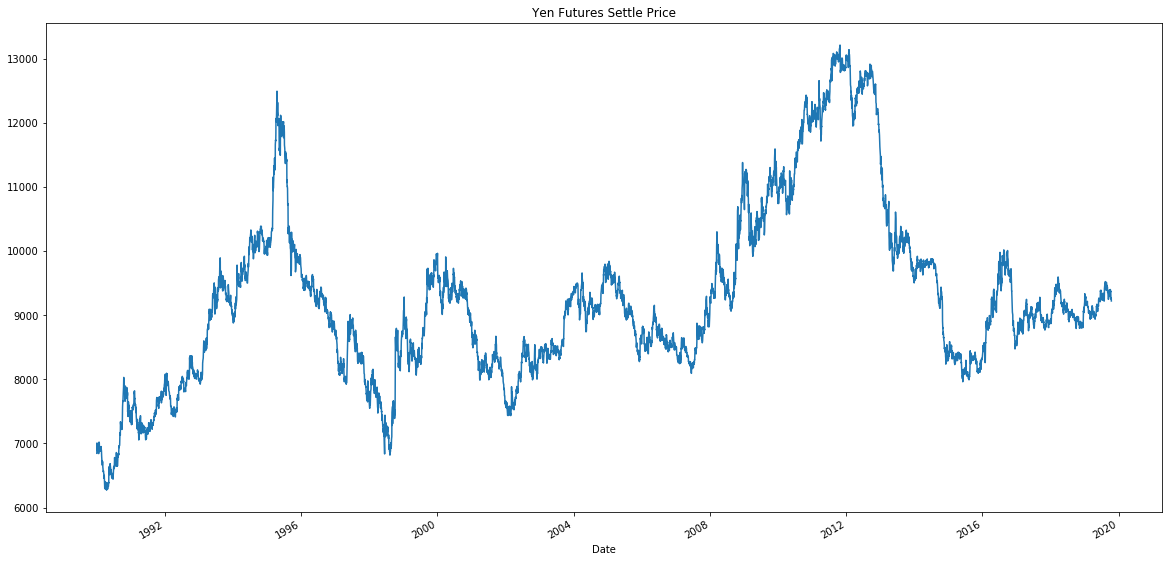

In [35]:
# Plot just the "Settle" column from the dataframe:
yen_futures.Settle.plot(figsize=(20,10),title="Yen Futures Settle Price")

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [36]:
import statsmodels.api as sm

yen_noise, yen_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])
# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:

In [37]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
yen_settle = pd.DataFrame(yen_futures['Settle'])
yen_settle['Noise'] = yen_noise
yen_settle['Trend'] = yen_trend
yen_settle.head()


,Settle,Noise,Trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


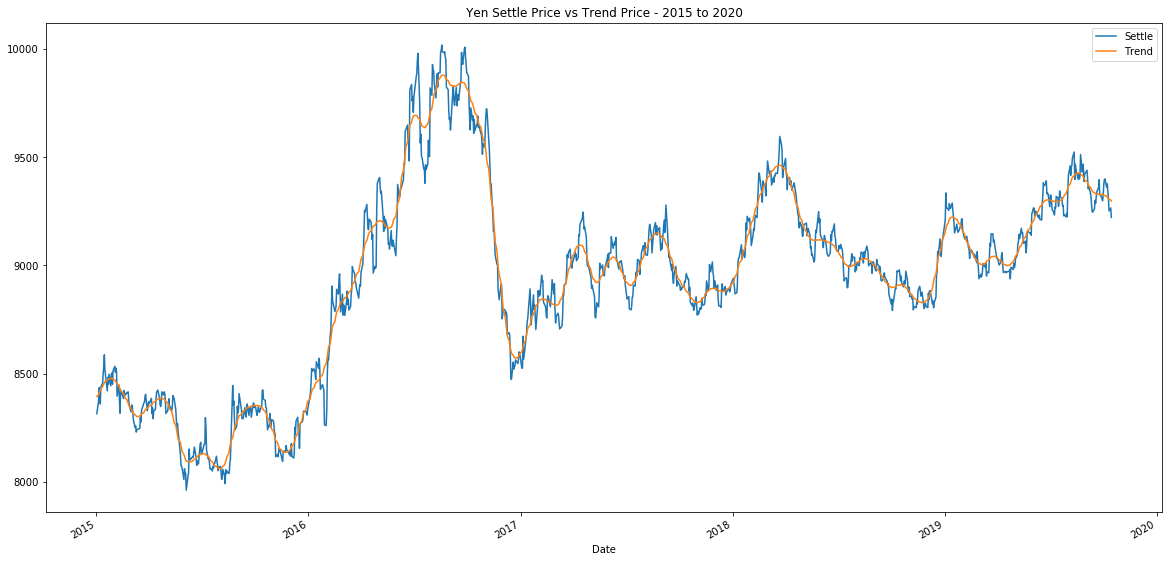

In [38]:
# Plot the Settle Price vs. the Trend for 2015 to the present
yen_2015_trend = yen_settle.loc["2015-01-01":, ['Settle','Trend']]
yen_2015_trend.plot(figsize=(20,10),title='Yen Settle Price vs Trend Price - 2015 to 2020')


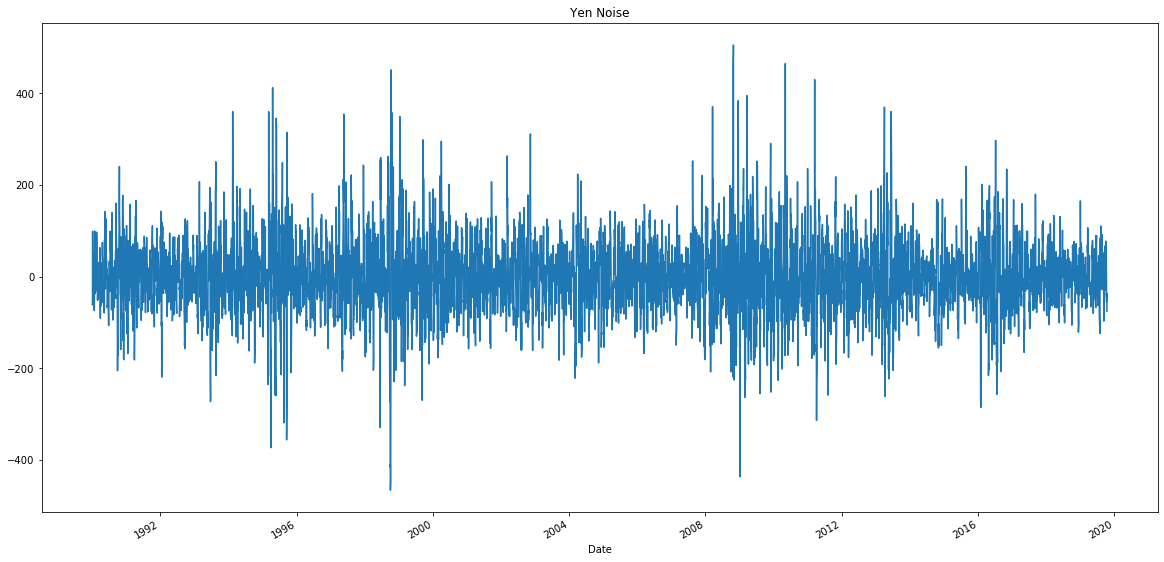

In [39]:
# Plot the Settle Noise
yen_settle['Noise'].plot(figsize=(20,10),title='Yen Noise')

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [40]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [41]:
import statsmodels.api as sm

from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()


In [42]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Thu, 05 Aug 2021   AIC                          15798.142
Time:                        23:15:15   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.421      -0.009       0.022
ar.L1.y       -0.3063      1.277     -0.240      0.810      -2.810       2.197
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2947      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3344           +0.0000j            3.3344            0.5000
AR.2         -157.1792           +0.0000j          157.1792            0.5000
MA.1           -3.3932           +0.0000j            3.3932            0.5000
-----------------------------------------------------------------------------
"""

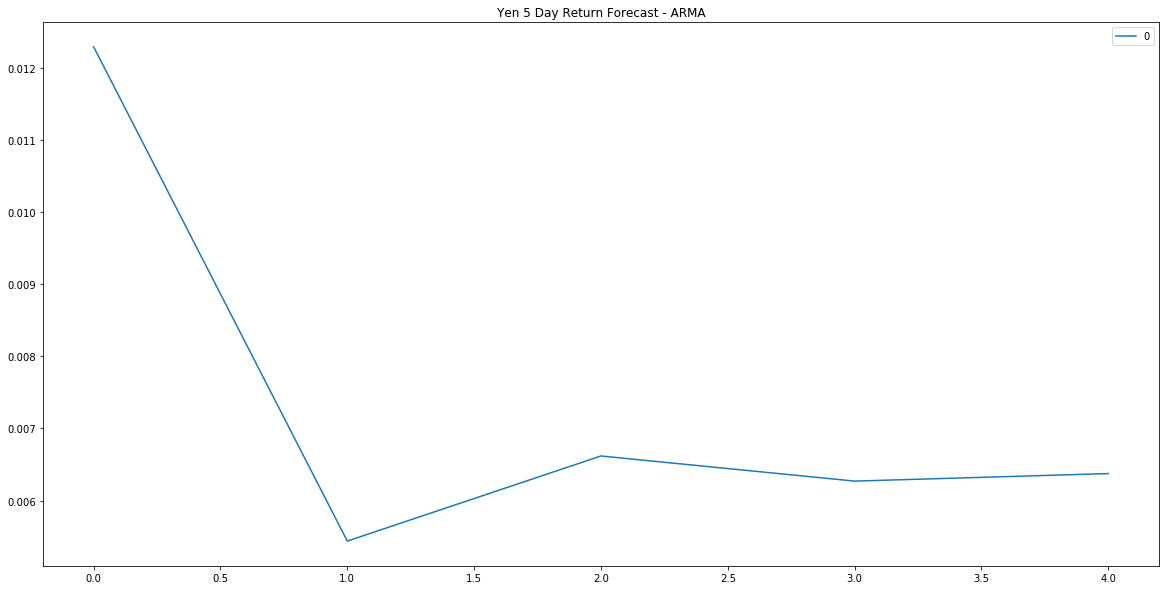

In [43]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="Yen 5 Day Return Forecast - ARMA", figsize=(20,10))

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [44]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(yen_futures[['Settle']], order=(5,1,1))

# Fit the model
results = model.fit()

C:\Users\Myles\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Myles\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [45]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Thu, 05 Aug 2021   AIC                          83905.238
Time:                        23:15:17   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3160      0.700      0.451      0.652      -1.056       1.688
ar.L1.D.Settle     0.2822      0.699      0.404      0.687      -1.088       1.653
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2972      0.699     -0.425      0.671      -1.667       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8918           -1.3786j            2.3408           -0.1002
AR.2            1.8918           +1.3786j            2.3408            0.1002
AR.3           -2.2700           -3.0207j            3.7786           -0.3526
AR.4           -2.2700           +3.0207j            3.7786            0.3526
AR.5          -11.0688           -0.0000j           11.0688           -0.5000
MA.1            3.3645           +0.0000j            3.3645            0.0000
-----------------------------------------------------------------------------
"""

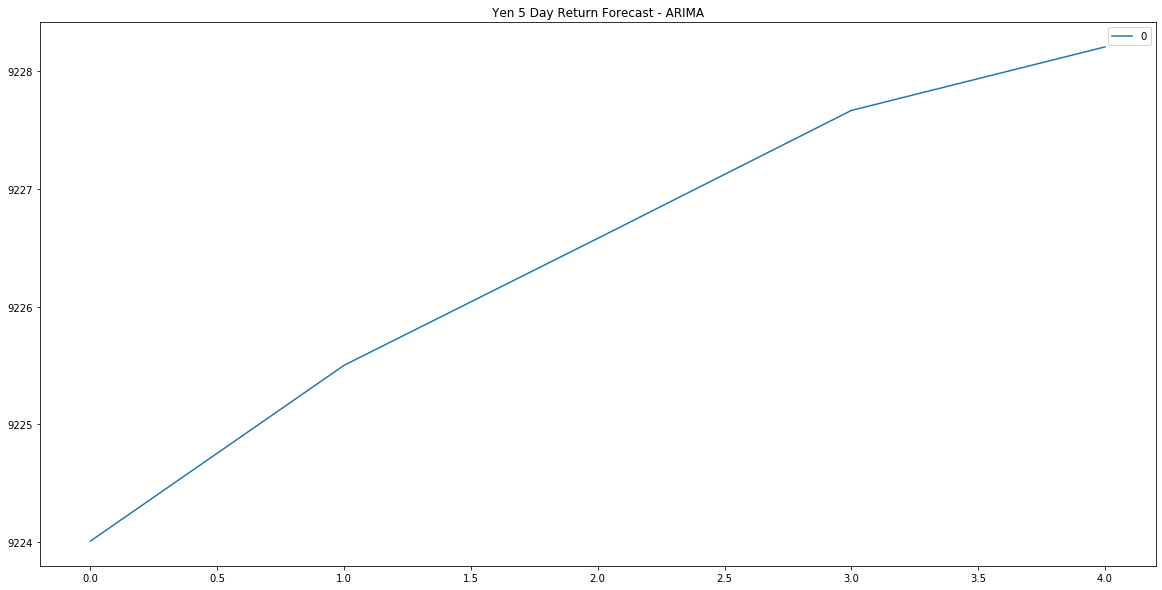

In [46]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="Yen 5 Day Return Forecast - ARIMA", figsize=(20,10))

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [47]:
import arch 

In [48]:
# Estimate a GARCH model:
model = arch.arch_model(returns, mean='Zero', vol='GARCH', p=2, q=1)

# Fit the model
results = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 87406254.62884925
Iteration:      2,   Func. Count:     14,   Neg. LLF: 8220.925448485285
Iteration:      3,   Func. Count:     22,   Neg. LLF: 7487.715051647085
Iteration:      4,   Func. Count:     28,   Neg. LLF: 7505.8233985962215
Iteration:      5,   Func. Count:     34,   Neg. LLF: 7479.046068867134
Iteration:      6,   Func. Count:     40,   Neg. LLF: 7895.737484233749
Iteration:      7,   Func. Count:     47,   Neg. LLF: 7462.4113697930225
Iteration:      8,   Func. Count:     52,   Neg. LLF: 7462.2146776534555
Iteration:      9,   Func. Count:     57,   Neg. LLF: 7462.021535648443
Iteration:     10,   Func. Count:     62,   Neg. LLF: 7461.935930634227
Iteration:     11,   Func. Count:     67,   Neg. LLF: 7461.927898024664
Iteration:     12,   Func. Count:     72,   Neg. LLF: 7461.927643351801
Iteration:     13,   Func. Count:     77,   Neg. LLF: 7461.927640221216
Iteration:     14,   Func. Count:     82,   Neg. LLF: 4239912

In [49]:
# Summarize the model results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Thu, Aug 05 2021   Df Residuals:                     7514
Time:                        23:15:18   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.707e-02  [2.571e-04,8.322e-03]
alpha[1]       0.0381  1.282e-02      2.970  2.974e-03  [1.295e-02,6.321e-02]
alpha[2]       0.0000  1.703e-02      0.000      1.000 [-3.338e-02,3.338e-02]
beta[1]        0.9536  1.420e-02     67.135      0.000      [  0.926,  0.981]
=============================================================================

Covariance estimator: robust
"""

In [50]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [51]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecast = results.forecast(start=last_day, horizon=forecast_horizon)

C:\Users\Myles\anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [52]:
# Annualize the forecast
intermediate = np.sqrt(forecast.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434032,7.475729,7.516851,7.55741,7.597418


In [53]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434032
h.2,7.475729
h.3,7.516851
h.4,7.557410
h.5,7.597418


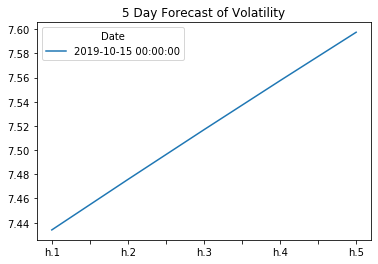

In [54]:
# Plot the final forecast
final.plot(title='5 Day Forecast of Volatility')

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Our ARMA & ARIMA models tell us that the yen is expected to increase in the next 5 days and thus would be a good purchase. 

Is the risk of the yen expected to increase or decrease?

As evidenced in the 5 Day Forecast of Volatility, our GARCH Forceast predicts an increase in volatility for the next 5 days of our sample.

Based on the model evaluation, would you feel confident in using these models for trading?


I would not feel confident in using these models for tradingHowever, the p-scores for the ARMA & ARIMA were .421 and .652 respectively and well over the recommended p-score of .05 for stationary data. In hopes of trying to make the data more stationary, I re-ran the ARMA model by taking another percent change from the initial return. The results were a P-Value of 0 and a prediction of a price decrease. I also re-ran the ARIMA model by using a '2' in the 'd' or 'Differences' parameter. By doing so, that instructs the formula to find the difference of the selected value, the daily return in this instance, twice instead of just once. Doing so brought our p-score down to .429. While this is not near the stationary threshold of 0.05, it should be considered more reliable than the initial ARIMA model. In it's second instance, the ARIMA model also predicted a decrease.

In combining the results of the updated price prediction with the expected increase in volatility, I would not feel comfortable purchasing the Yen.

In [55]:

# Create a returns2 variable to store the stationary df. I divided the percentages by 100 as there were multiplied by 100 in the beginning of the module
returns2 = (returns.pct_change())/100

# Take out both negative and positive infs
returns2 = returns2.replace(np.inf, np.nan).dropna()
returns2 = returns2.replace(-np.inf, np.nan).dropna()

returns2.head()

,Settle
Date,
1990-01-04,0.020074
1990-01-05,-0.014711
1990-01-08,-0.011565
1990-01-09,-0.058826
1990-01-10,-0.003596


## Notice that the P-value is 0 and thus stationary

In [56]:
# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns2.values, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7407
Model:                     ARMA(2, 1)   Log Likelihood                6383.041
Method:                       css-mle   S.D. of innovations              0.102
Date:                Thu, 05 Aug 2021   AIC                         -12756.081
Time:                        23:15:19   BIC                         -12721.530
Sample:                             0   HQIC                        -12744.209
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0100      0.001     -8.449      0.000      -0.012      -0.008
ar.L1.y       -0.1837      0.945     -0.194      0.846      -2.036       1.668
ar.L2.y       -0.0038      0.012     -0.324      0.746      -0.027       0.019
ma.L1.y        0.1837      0.945      0.194      0.846      -1.668       2.035
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -6.2414           +0.0000j            6.2414            0.5000
AR.2          -42.5136           +0.0000j           42.5136            0.5000
MA.1           -5.4449           +0.0000j            5.4449            0.5000
-----------------------------------------------------------------------------
"""

Notice that the P-value is 0, meaning our data is now stationary.

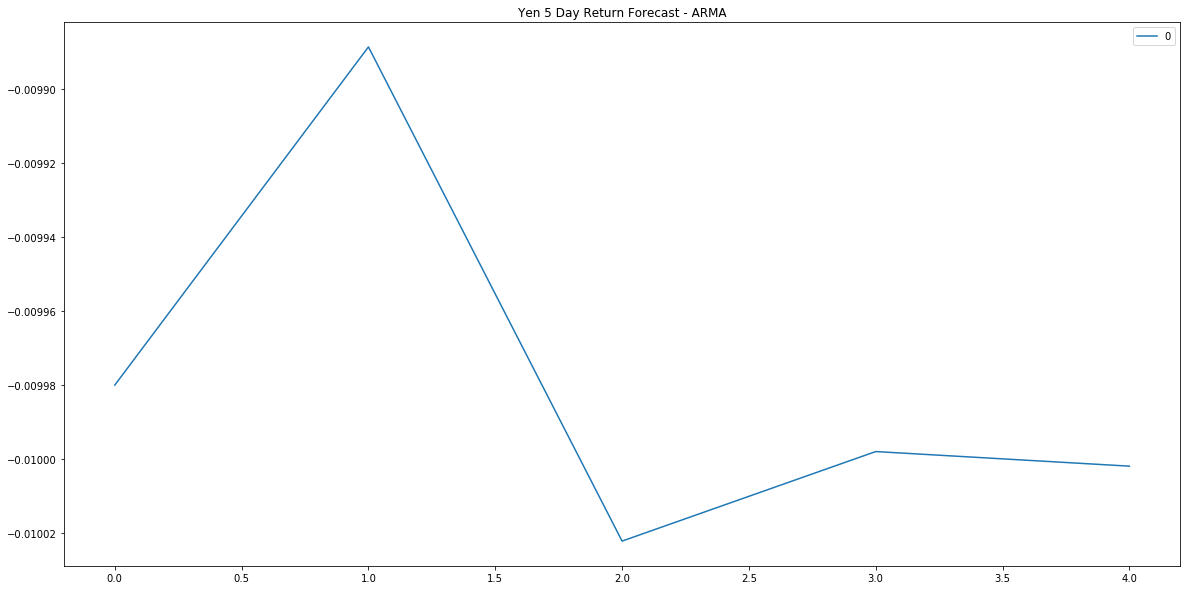

In [57]:
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="Yen 5 Day Return Forecast - ARMA", figsize=(20,10))

The updated ARMA model implies a slight decrease in the 5 day forecast.

In [58]:
model = ARIMA(yen_futures[['Settle']], order=(5,2,1))

# Fit the model
results2 = model.fit()
results2.summary()


C:\Users\Myles\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Myles\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D2.Settle   No. Observations:                 7513
Model:                 ARIMA(5, 2, 1)   Log Likelihood              -41943.812
Method:                       css-mle   S.D. of innovations             64.284
Date:                Thu, 05 Aug 2021   AIC                          83903.624
Time:                        23:15:26   BIC                          83959.019
Sample:                             2   HQIC                         83922.645
                                                                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0003      0.000     -0.790      0.429      -0.001       0.000
ar.L1.D2.Settle    -0.0146      0.012     -1.266      0.206      -0.037       0.008
ar.L2.D2.Settle    -0.0035      0.012     -0.305      0.761      -0.026       0.019
ar.L3.D2.Settle    -0.0138      0.012     -1.199      0.230      -0.036       0.009
ar.L4.D2.Settle    -0.0177      0.012     -1.532      0.126      -0.040       0.005
ar.L5.D2.Settle    -0.0051      0.012     -0.442      0.658      -0.028       0.018
ma.L1.D2.Settle    -1.0000      0.000  -2500.389      0.000      -1.001      -0.999
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7381           -1.6525j            2.3983           -0.1210
AR.2            1.7381           +1.6525j            2.3983            0.1210
AR.3           -1.6013           -2.5594j            3.0191           -0.3390
AR.4           -1.6013           +2.5594j            3.0191            0.3390
AR.5           -3.7371           -0.0000j            3.7371           -0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

The P-value has gone down to .429 from .652. While it is still not stationary, it should be considered slightly more reliable.The 

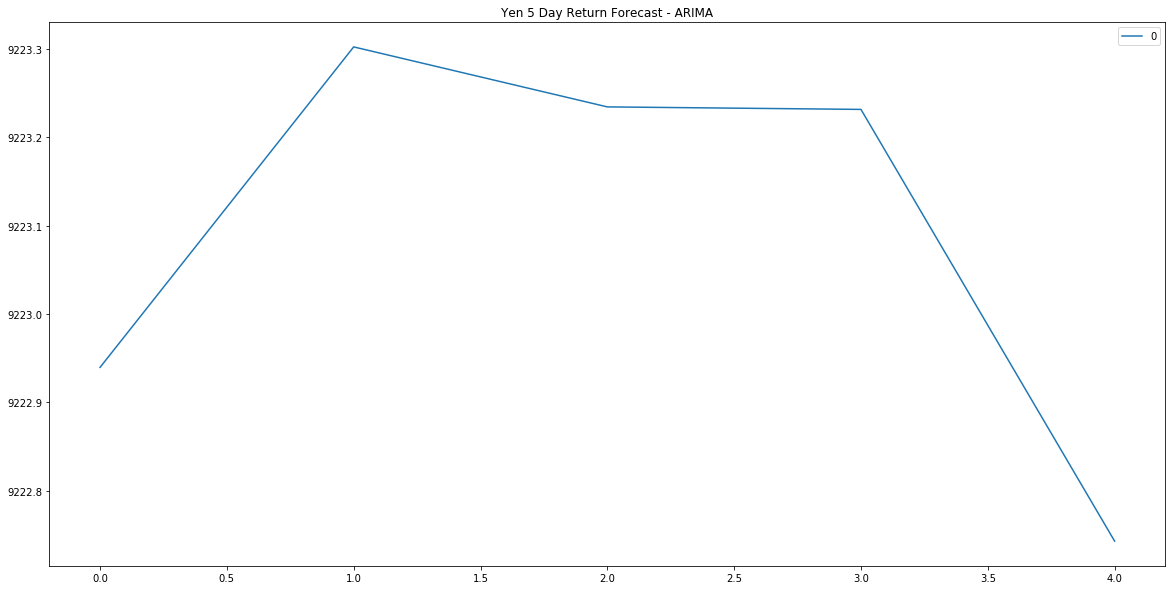

In [59]:
pd.DataFrame(results2.forecast(steps=5)[0]).plot(title="Yen 5 Day Return Forecast - ARIMA",figsize=(20,10))

The updated ARIMA forecast calls for a slight decrease as well.